In [1]:
# setup
# file
import os

# Data Processing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# explain
import seaborn as sns
import shap

# folder
folder_input = '02_input'



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# import data
cleaned_data = pd.read_csv(os.path.join('..', folder_input, 'cleaned_data.csv'))


In [3]:
# train vs test
# seperate target from predictors
X = cleaned_data.copy()            # use copy, not to affect original dataset
y = X.pop('Churn')        # y = "churn", and delete churn from X

# train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [4]:
# preprocessing for categorical data
cleaned_data.info()

# select categorical columns
# PS: [categorical_cols] mean == True
categorical_cols = X_train.dtypes == 'object'
categorical_cols = list(categorical_cols[categorical_cols].index)  
categorical_cols    

# one hot encoder
# PS: The one hot encoder output is a series, need to turn to dataframe
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(X_test[categorical_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# add back colnames
OH_cols_train.columns = OH_encoder.get_feature_names_out()
OH_cols_test.columns = OH_encoder.get_feature_names_out()


# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(categorical_cols, axis=1)
num_X_test = X_test.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_test = pd.concat([num_X_test, OH_cols_test], axis=1)


X_train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 7043 non-null   object 
 1   SeniorCitizen          7043 non-null   int64  
 2   Partner                7043 non-null   object 
 3   Dependents             7043 non-null   object 
 4   tenure                 7043 non-null   int64  
 5   PhoneService           7043 non-null   object 
 6   MultipleLines          7043 non-null   object 
 7   InternetService        7043 non-null   object 
 8   OnlineSecurity         7043 non-null   object 
 9   OnlineBackup           7043 non-null   object 
 10  DeviceProtection       7043 non-null   object 
 11  TechSupport            7043 non-null   object 
 12  StreamingTV            7043 non-null   object 
 13  StreamingMovies        7043 non-null   object 
 14  Contract               7043 non-null   object 
 15  Pape

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,SeniorCitizen,tenure,Is_Contract_Locked,FamilySize,MonthlyChargesPerHead,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3296,0,19,False,1,84.750000,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6397,0,72,True,3,23.816667,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
6043,0,61,False,3,33.050000,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5309,0,34,True,3,8.316667,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3000,0,71,True,1,53.950000,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [6]:
# # preprocessing for numerical data
# # select numericial columns
# numericial_cols = cleaned_data.dtypes.isin(['int64', 'float64'])
# numericial_cols = list(numericial_cols[numericial_cols].index)  
# numericial_cols

# # scaler
# num_encoder = StandardScaler()
# num_cols_train = pd.DataFrame(num_encoder.fit_transform(X_train[numericial_cols]))
# num_cols_test = pd.DataFrame(num_encoder.fit_transform(X_test[numericial_cols]))

# # One-hot encoding removed index; put it back
# num_cols_train.index = X_train.index
# num_cols_test.index = X_test.index

# # add back colnames
# num_cols_train.columns = num_encoder.get_feature_names_out()
# num_cols_test.columns = num_encoder.get_feature_names_out()

# # Remove numerical  columns (will replace with encoding)
# cat_X_train = X_train.drop(numericial_cols, axis=1)
# cat_X_test = X_test.drop(numericial_cols, axis=1)

# # Add one-hot encoded columns to numerical features
# X_train = pd.concat([cat_X_train, num_cols_train], axis=1)
# X_test = pd.concat([cat_X_test, num_cols_test], axis=1)


# X_train.head()



ValueError: at least one array or dtype is required

In [5]:
# xgboost
xgbmodel = XGBClassifier(n_estimators = 1000)
xgbmodel.fit(
    X_train,
    y_train
)

# prediction
preds = xgbmodel.predict(X_test)

In [6]:
# evaluation
accuracy_score(y_test, preds)

0.7791027825099376

In [7]:
# confusion matrix
confusion_matrix(y_test, preds)

array([[1130,  173],
       [ 216,  242]], dtype=int64)

In [8]:
# classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.84      0.87      0.85      1303
        True       0.58      0.53      0.55       458

    accuracy                           0.78      1761
   macro avg       0.71      0.70      0.70      1761
weighted avg       0.77      0.78      0.78      1761



<Axes: >

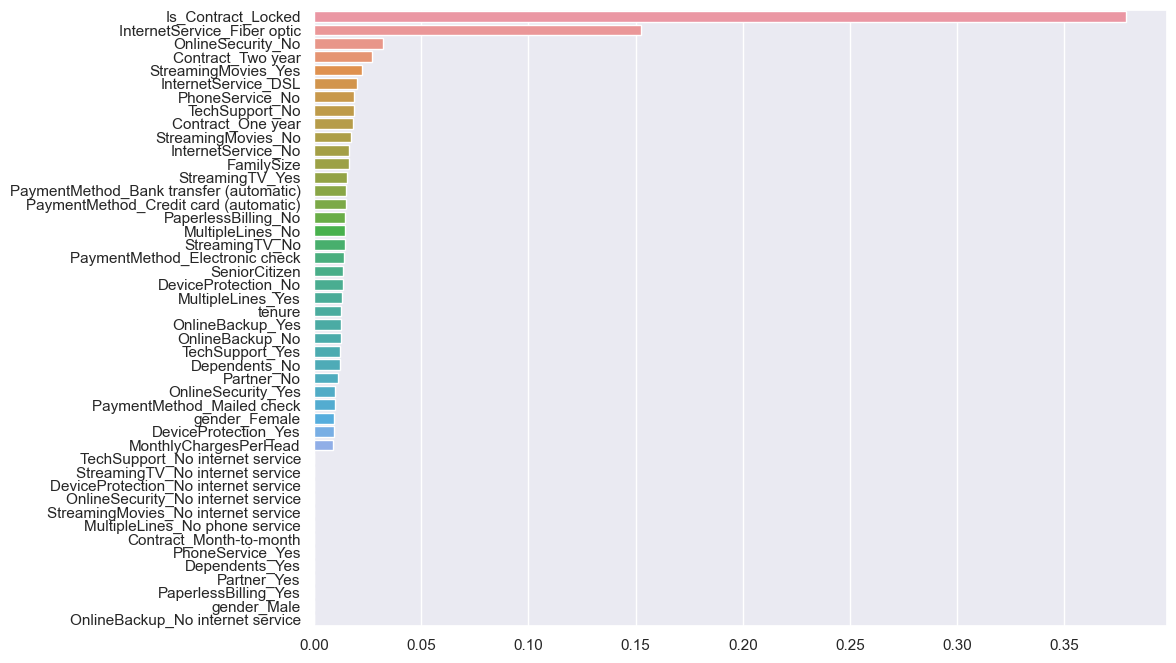

In [9]:
# feature importance
xgb_importance = pd.Series(xgbmodel.feature_importances_, index=X_train.columns).sort_values(ascending= False)
xgb_importance

# plot it
sns.set(rc={'figure.figsize':(11,8)})
sns.barplot(x = xgb_importance.values,
            y = xgb_importance.index)